# Modern techniques for scientific computing and data science (1/n)

If you're anything like me, you've picked up some python programming in order to solve a problem or maybe as part of a class in computing. Many of us picked up this langauge as a means to an end and started learning via google and stack overflow. When learning like this, it's easy to miss some of the new devlopments in the python landscape. This post is a first in an arbitrary number of posts describing a few techniques I consider must-haves in modern python development. The field moves extremely fast, so I'll try to restrict myself to tools that I consider so useful, that the payoff of learning them is well worth the effort.

## Part 1: Altair + Dataclasses + Callable classes

In python, functions are objects, and objects are functions. To make an object 
callable using `f(x)` syntax, all you have to do is define the `__call__` method.
Let's try it out with a class that squares a number:

In [8]:
class Squared:
    def __call__(self, x):
        return x * x

squared = Squared()  # Instantiate the class
squared(2)

4

Ok, that's pretty useless. But what about storing a value to use later? We can
use this to create a class that is parameterized. We can instantiate the class
with a parameter, and then call it later. This is effectively "partial function application", which allows us to convert `f(x, n)` to `f(x)` by "binding" a value for `n`

In [27]:
class Power:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        return x ** self.n
    
# Instantiate Power with different exponents
cubed = Power(3)
pow5 = Power(5)

# Now the instances remember the value of n they were instantiated with
print("2 cubed = ", cubed(2))
print("2 ^ 5 = ", pow5(2))

2 cubed =  8
2 ^ 5 =  32


Alright, so we can create various functions on the fly, and invoke them later. 
Let's take a look at what one looks like:

In [15]:
print(cubed)

Bummer. That's not helpful at all! But what if we could make a new function,
but also be able to print it out? That'd be kinda nice. The way to define a 
custom print function for a python class is to write a `__str__` method. 
I don't want to do that, so I'm going to make python do it for me. 
Enter dataclasses, a new way in python 3.7 to auto generate a lot of 
boilerplate involved when writing classes. Simply decorate our function
with `@dataclass` and add annotations for the variables we want to store. 
In this case we're saying that the class has a variable named `n` and it is
expected to be integer. 

In [28]:
from dataclasses import dataclass

@dataclass
class Dataclass_Pow:
    n: int
    def __call__(self, x):
        return x ** self.n
    
dataclass_pow4 = Dataclass_Pow(n=4)
print("2 ^ 4 = ", dataclass_pow4(2))

2 ^ 4 =  16


Notice how we didn't have to define `__init__` anymore! Now we've really only specified
what `Dataclass_Pow` should do when called, and what variables it needs to save. And
look what happens when we print it out:

In [29]:
print(dataclass_pow4)

Dataclass_Pow(n=4)


Now that's what I call descriptive! Let's Try it out with something a bit more complicated:

In [31]:
from math import factorial
import numpy as np
import pandas as pd

@dataclass
class Gaussian:
    mu: float
    sigma: float
        
    def __call__(self, x):
        N = 1.0 / np.sqrt(2 * np.pi * self.sigma**2)
        return N * np.exp(-(x - self.mu)**2 / (2 * self.sigma**2))

Now that we can make gaussians as we want, let's make a few:

In [33]:
gaussians = [
    Gaussian(mu=-3, sigma=2),
    Gaussian(mu=-1, sigma=1.5),
    Gaussian(mu=1, sigma=1),
    Gaussian(mu=2, sigma=0.5)
]
gaussians

[Gaussian(mu=-3, sigma=2),
 Gaussian(mu=-1, sigma=1.5),
 Gaussian(mu=1, sigma=1),
 Gaussian(mu=2, sigma=0.5)]

Look! We can make a bunch of functions, and print them all out at once! Let's see if we 
can do something a bit more interesting: We can tabulate the values of each
gaussian over a grid of x values, all while keeping track of which function was
used to generate the data.

In [43]:
x = np.linspace(-10, 5, 300)
data = []
for g in gaussians:
    # Evaluate the gaussian over x values, store in dict along with its name
    func_dict = {"x": x, "g(x)": g(x), "Func": str(g)}
    # Convert to dataframe
    func_df = pd.DataFrame(func_dict)
    # Add to list of dataframes
    data.append(func_df)
    
# Merge all of our dataframes into one
df = pd.concat(data)
df.head()

,x,g(x),Func
0,-10.000000,0.000436,"Gaussian(mu=-3, sigma=2)"
1,-9.949833,0.000476,"Gaussian(mu=-3, sigma=2)"
2,-9.899666,0.000519,"Gaussian(mu=-3, sigma=2)"
3,-9.849498,0.000566,"Gaussian(mu=-3, sigma=2)"
4,-9.799331,0.000617,"Gaussian(mu=-3, sigma=2)"


And boom! A big dataframe holding all of our gaussians, along with their x, g(x) and parameters! Better yet, we can keep the `Func` column around to group the values by
function. Even better still, we can make altair do all the heavy lifting.

Altair is a relatively recent addition to the python data visualization landscape. 
It allows us to declaratively specify plots for pandas dataframes. 
Let's throw in our table of gaussian data. Then we can tell it to plot
`g(x)` vs `x`, with different colors for each gaussian. Let's see how easy 
it is:

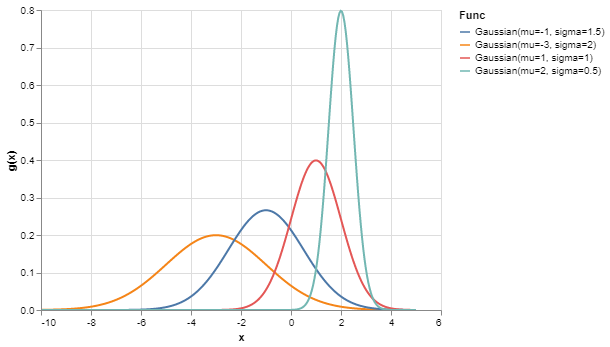

In [44]:
import altair as alt
alt.Chart(df).mark_line().encode(
    x="x",
    y="g(x)",
    color="Func"
)

Bam! That's it! Just a few lines. This short snippet of code plotted
all of our functions and colored them differently. Additionally, It was able
to generate a very detailed legend detailing all of our parameters. Since
all of this was done so automatically, there's no chance for us to mix up 
our labels and functions, to boot.

And if we want to split our functions into different plots, we
only have to change `color` to `row`.

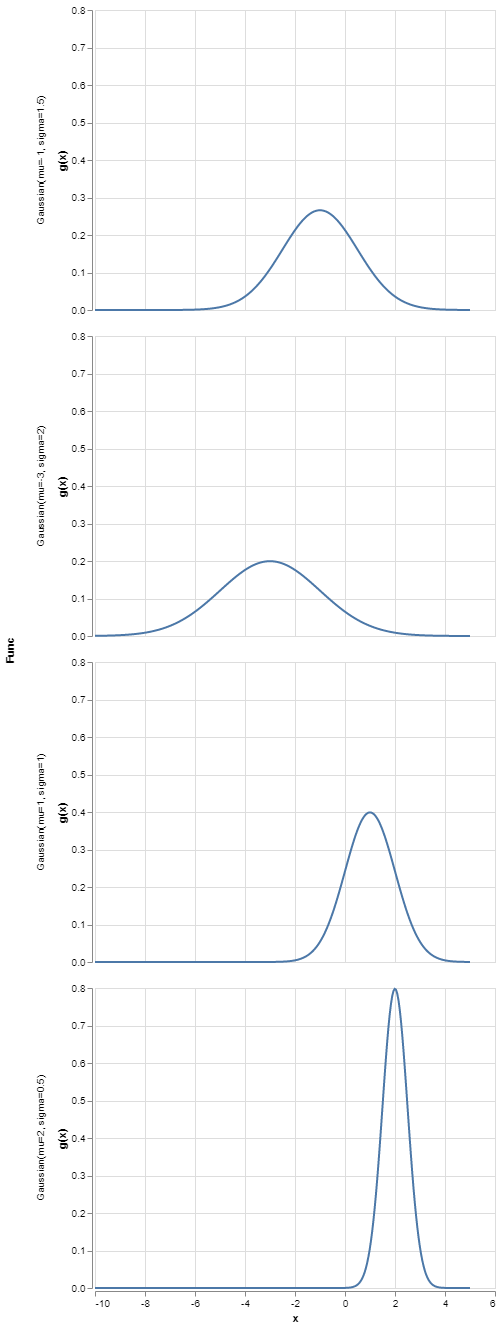

In [49]:
alt.Chart(df).mark_line().encode(
    x="x",
    y="g(x)",
    row="Func"
)

And there we have it! A simple way to keep track of arbitrary
functions and visualize them. 

We've learned that python classes can behave like functions, and we can
use them to store parameters to be used later. We can combine this with the
recent feature of dataclasses to get a bunch of convenient bookkeeping for free.

Additionally, this allows us to create convenient labels for our plots, with 
no chance of error!

Hopefully this was a neat intro to a few python techniques that you might
not come across if you're just googling around to solve a specific problem. 
In the future, I plan on releasing a few more interesting tips that 
aren't so obvious.

